This notebook reads numpy arrays created by processMexicoData.ipynb. The processed data are then used to fine-tune the VGG16 model that has already been pre-trained on ImageNet data.

NB The notebook is set up for binary categories only ATM

In [ ]:
!pip install livelossplot

In [3]:
%load_ext autoreload
%autoreload 2

import sys
import os
import numpy as np
import matplotlib.pyplot as plt
from google.colab import drive
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.models import load_model
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Input, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from livelossplot.inputs.keras import PlotLossesCallback

In [4]:
drive.mount('/content/drive')
sys.path.append('/content/drive/MyDrive/Colab Notebooks/')
import utils

Mounted at /content/drive


In [5]:
# Read the numpy arrays containing Sentinel image snippets

states = ["Guanajuato", "Queretaro", "Sonora", "Yucatan"]
images_cat1 = []
images_cat0 = []

# The original datasets

for state in states:
  images_cat1.append(np.load(f'/content/drive/MyDrive/CAFO_data/Mexico/{state}_cat1_edited.npy'))
  images_cat0.append(np.load(f'/content/drive/MyDrive/CAFO_data/Mexico/{state}_cat0_edited.npy'))

images_cat1 = np.concatenate(images_cat1, axis=0)
images_cat0 = np.concatenate(images_cat0, axis=0)

print(f"There are {images_cat1.shape[0]} CAFO images")
print(f"There are {images_cat0.shape[0]} not-CAFO images")

There are 768 CAFO images
There are 821 not-CAFO images


In [6]:
# Create training, validation, and test datasets from those arrays

# Combine all the farm and not-farm images into a single array
images = np.concatenate([images_cat1, images_cat0], axis=0)

# Create an array of image labels
labels_cat1 = np.ones(len(images_cat1))
labels_cat0 = np.zeros(len(images_cat0))
labels = np.concatenate([labels_cat1, labels_cat0], axis=0)
labels = to_categorical(labels, num_classes=2)

# Randomly shuffle images and labels in unison
indices = np.arange(images.shape[0])
np.random.shuffle(indices) #Is there a default seed for this?
images = images[indices]
labels = labels[indices]

# Split into training + validation and test sets
X_train_val, X_test, y_train_val, y_test = train_test_split(
    images, labels, test_size=0.10, random_state=42)  # 10% for testing

# Split training + validation into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.22, random_state=42)  # ~20% for validation

# Keep copies of original data as the arrays can get changed by the data generators
X_train_original = np.copy(X_train)
X_val_original = np.copy(X_val)
X_test_original = np.copy(X_test)

In [7]:
# Set up data generators, augmenting training data but not validation + test data

train_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    vertical_flip=True,
    preprocessing_function=preprocess_input
    )

val_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
    )

In [8]:
# Create the model so as to fine-tune only the top 2 (non-convolutional) layers
# This is essentially extracting features and re-learning how to classify based on them

input_shape=X_train.shape[1:]
n_classes = 2
optimizer=Adam(learning_rate=0.001)
weights_file = None #'/content/drive/MyDrive/CAFO_models/VGG16_step1.keras'

# Load pretrained layers, excluding fully-connected layers
base_model = VGG16(include_top=False,
                  weights='imagenet',
                  input_shape=input_shape)

# Freeze pretrained layers
base_model.trainable = False

# Create new fully-connected layers for classification
top_model = base_model.output
top_model = Flatten(name="flatten")(top_model)
top_model = Dense(512, activation='relu')(top_model)
top_model = Dropout(0.5)(top_model)
top_model = Dense(256, activation='relu')(top_model)
top_model = Dropout(0.5)(top_model)
output_layer = Dense(n_classes, activation='softmax')(top_model)

# Combine the base (convolutional) and top (fully-connected) layers
model = Model(inputs=base_model.input, outputs=output_layer)

# If we have already done this step, can load saved weights from file
if weights_file is not None:
  print(f'Loading model from {weights_file}')
  model.load_weights(weights_file)

# Compile the model for training.
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

58889256/58889256 [==============================] - 0s 0us/step


In [ ]:
# Define early stopping + other callbacks. See
# machinelearningmastery.com/how-to-stop-training-deep-neural-networks-at-the-right-time-using-early-stopping/

lr = ReduceLROnPlateau(
                      factor=0.5,
                      monitor='val_loss',
                      min_delta=0,
                      patience=3,
                      min_lr=1e-6,
                      verbose=2
                      )

es = EarlyStopping(
                  monitor='val_loss',
                  mode='min',
                  restore_best_weights=True,
                  min_delta=0,
                  patience=6,
                  verbose=2
                  )

mc = ModelCheckpoint(
                    '/content/drive/MyDrive/CAFO_models/VGG16_step1.keras',
                    monitor='val_accuracy',
                    mode='max',
                    verbose=2,
                    save_best_only=True
                    )

pl = PlotLossesCallback()

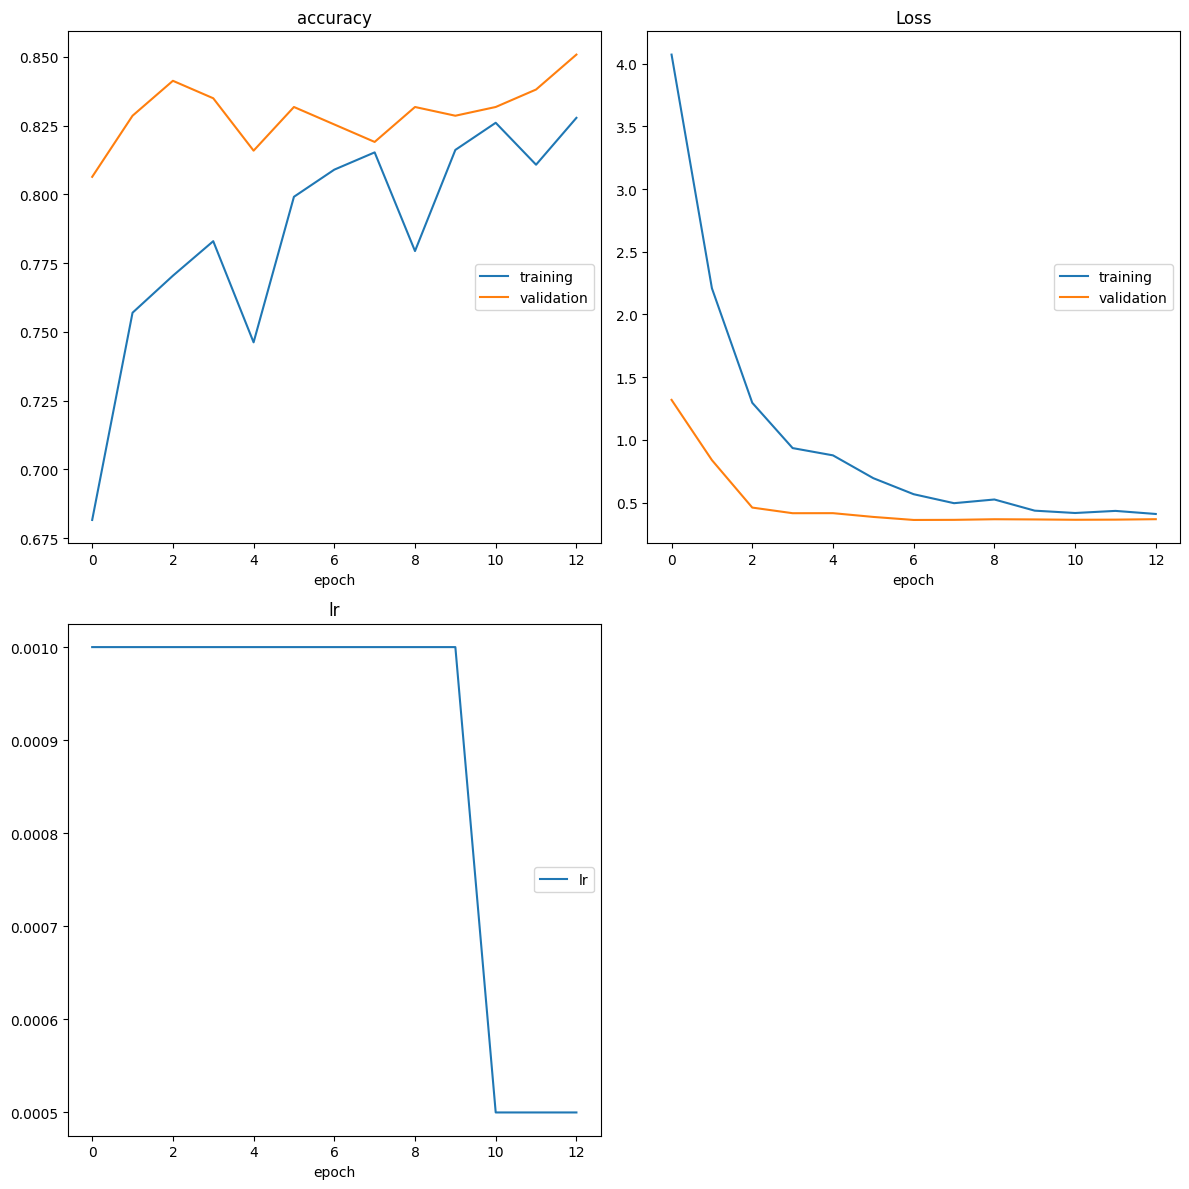

accuracy
	training         	 (min:    0.682, max:    0.828, cur:    0.828)
	validation       	 (min:    0.806, max:    0.851, cur:    0.851)
Loss
	training         	 (min:    0.409, max:    4.073, cur:    0.409)
	validation       	 (min:    0.361, max:    1.319, cur:    0.367)
lr
	lr               	 (min:    0.001, max:    0.001, cur:    0.001)
35/35 - 75s - loss: 0.4086 - accuracy: 0.8278 - val_loss: 0.3669 - val_accuracy: 0.8508 - lr: 5.0000e-04 - 75s/epoch - 2s/step
Epoch 13: early stopping


In [10]:
# Fit the model, if we haven't reloaded a previously-fitted one

if weights_file is None:

  history = model.fit(
                    train_datagen.flow(X_train, y_train, batch_size=32),
                    validation_data=val_datagen.flow(X_val, y_val, batch_size=32),
                    epochs=50,
                    callbacks=[lr, es, mc, pl],
                    verbose=2
                    )

In [11]:
# Use the model to make predictions for the test data. As
# EarlyStopping.restore_best_weights=True, this should be the best model,
# not just the last epoch's one

y_prob, y_class = utils.get_predictions(model, X_test)
df = utils.collect_results(y_prob, y_test)

5/5 [==============================] - 6s 1s/step


In [12]:
# Generate sklearn classification report

print('\n', classification_report(y_test, y_class))


               precision    recall  f1-score   support

           0       0.95      0.71      0.81        79
           1       0.77      0.96      0.86        80

   micro avg       0.84      0.84      0.84       159
   macro avg       0.86      0.84      0.83       159
weighted avg       0.86      0.84      0.83       159
 samples avg       0.84      0.84      0.84       159



In [13]:
# Show some of the correctly- and incorrectly-classified images

utils.plot_classified_images(X_test, df)

Output hidden; open in https://colab.research.google.com to view.

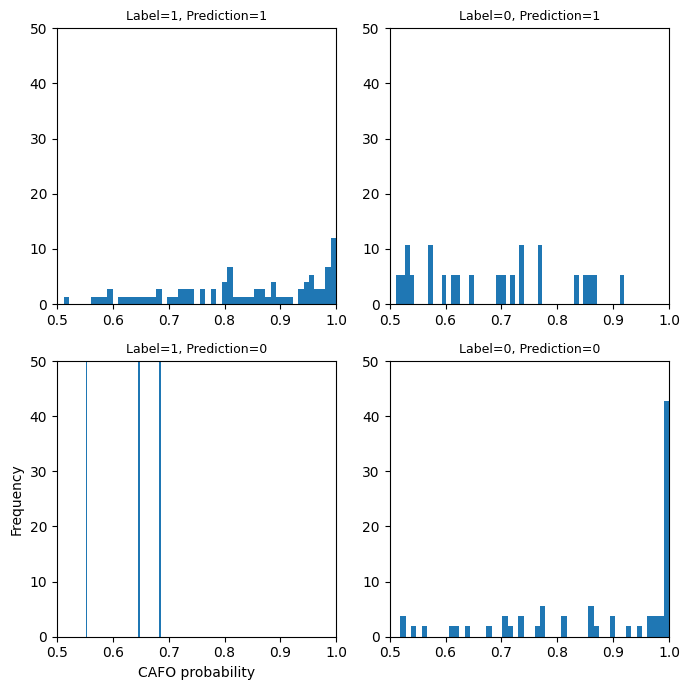

In [14]:
# Distribution of probabilities for correctly- and incorrectly-classified images

utils.probability_hist(df)

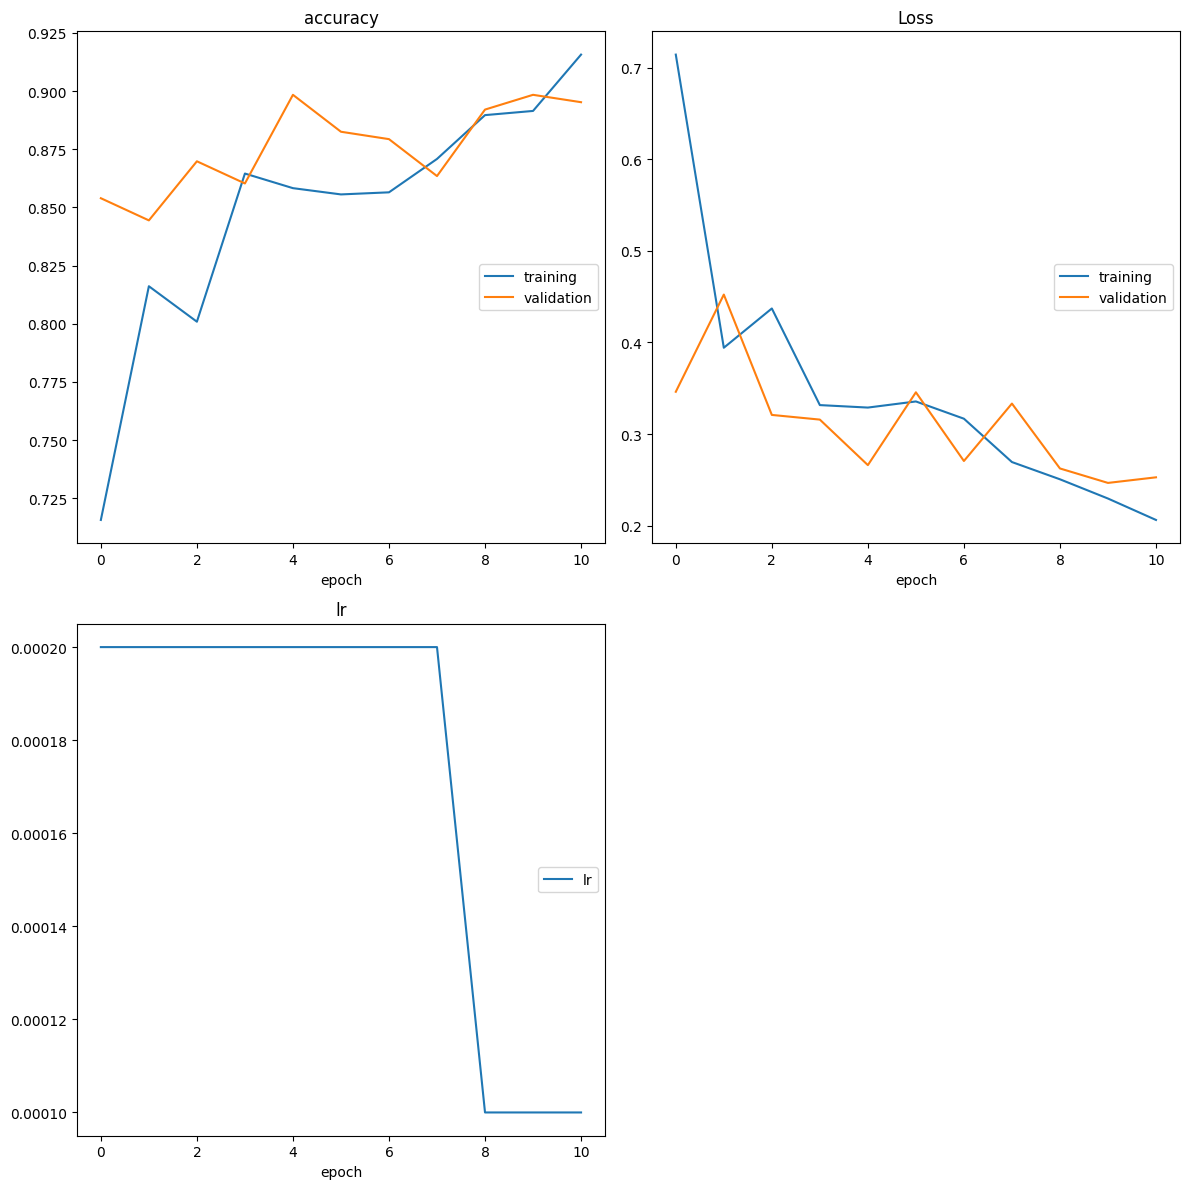

accuracy
	training         	 (min:    0.716, max:    0.916, cur:    0.916)
	validation       	 (min:    0.844, max:    0.898, cur:    0.895)
Loss
	training         	 (min:    0.206, max:    0.715, cur:    0.206)
	validation       	 (min:    0.247, max:    0.452, cur:    0.253)
lr
	lr               	 (min:    0.000, max:    0.000, cur:    0.000)
35/35 - 91s - loss: 0.2061 - accuracy: 0.9157 - val_loss: 0.2527 - val_accuracy: 0.8952 - lr: 1.0000e-04 - 91s/epoch - 3s/step
Epoch 11: early stopping


In [17]:
# Fine-tune the model

# Set the top few convolutional layers to be trainable
#  --- Do blocks not layers?
for layer in base_model.layers[-4:]:
    layer.trainable = True
    print(f"Layer {layer.name} is trainable")

# Compile the model with a lower learning rate
# Model compiling does not change weights; see
# stackoverflow.com/questions/47995324/does-model-compile-initialize-all-the-weights-and-biases-in-keras-tensorflow
optimizer=Adam(learning_rate=0.001*0.2)
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Update parameters for Reduce LR and EarlyStopping to reduce overfitting
lr = ReduceLROnPlateau(
                      factor=0.5,
                      monitor='val_loss',
                      min_delta=0.03,
                      patience=3,
                      min_lr=1e-6,
                      verbose=2
                      )

es = EarlyStopping(
                  monitor='val_loss',
                  mode='min',
                  restore_best_weights=True,
                  min_delta=0.03,
                  patience=6,
                  verbose=2
                  )

# Specify a new filename for best model
mc = ModelCheckpoint(
                    '/content/drive/MyDrive/CAFO_models/VGG16_step2.keras',
                    monitor='val_accuracy',
                    mode='max',
                    verbose=2,
                    save_best_only=True
                    )

# Reset the plots
pl = PlotLossesCallback()

# Uncomment if this fine-tuning step is interrupted and restarted
# Otherwise fitting will presumably continue with most recent weights
#weights_file = '/content/drive/MyDrive/CAFO_models/VGG16_step1.keras'
#model.load_weights(weights_file)

# Fit the model
ft_history = model.fit(
                    train_datagen.flow(X_train, y_train, batch_size=32),
                    validation_data=val_datagen.flow(X_val, y_val, batch_size=32),
                    epochs=70, #base epochs + fine-tuning ones?
                    callbacks=[lr, mc, es, pl],
                    verbose=2
                    )

In [20]:
y_prob_ft, y_class_ft = utils.get_predictions(model, X_test)

df_ft = utils.collect_results(y_prob_ft, y_test)

5/5 [==============================] - 8s 2s/step


In [21]:
print('\n', classification_report(y_test, y_class_ft))


               precision    recall  f1-score   support

           0       0.96      0.89      0.92        79
           1       0.90      0.96      0.93        80

   micro avg       0.92      0.92      0.92       159
   macro avg       0.93      0.92      0.92       159
weighted avg       0.93      0.92      0.92       159
 samples avg       0.92      0.92      0.92       159



77 of 159 images had label=1, prediction=1
9 of 159 images had label=0, prediction=1
3 of 159 images had label=1, prediction=0
70 of 159 images had label=0, prediction=0


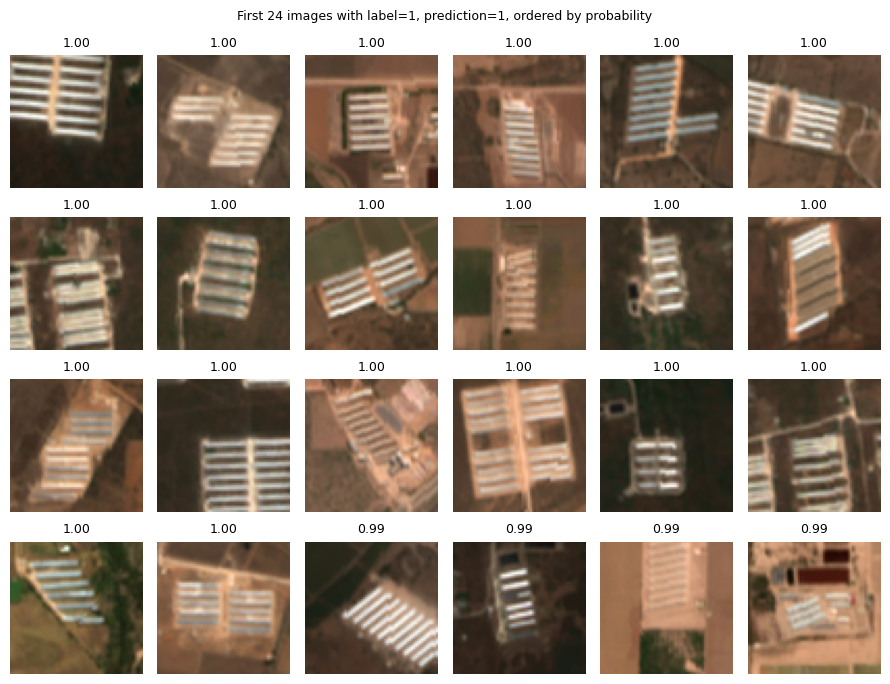

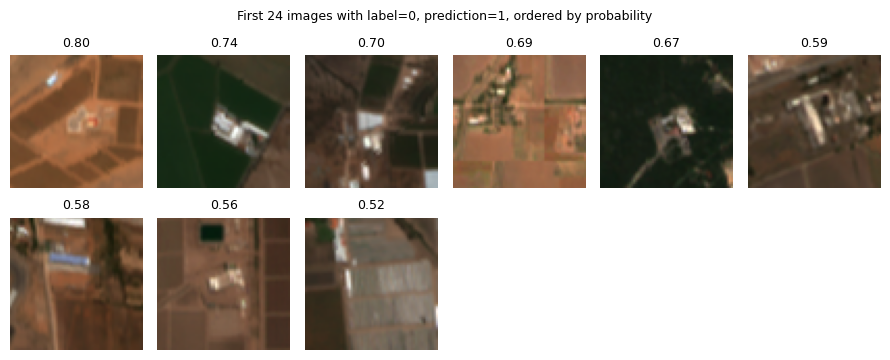

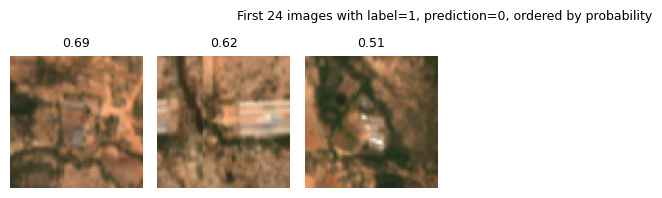

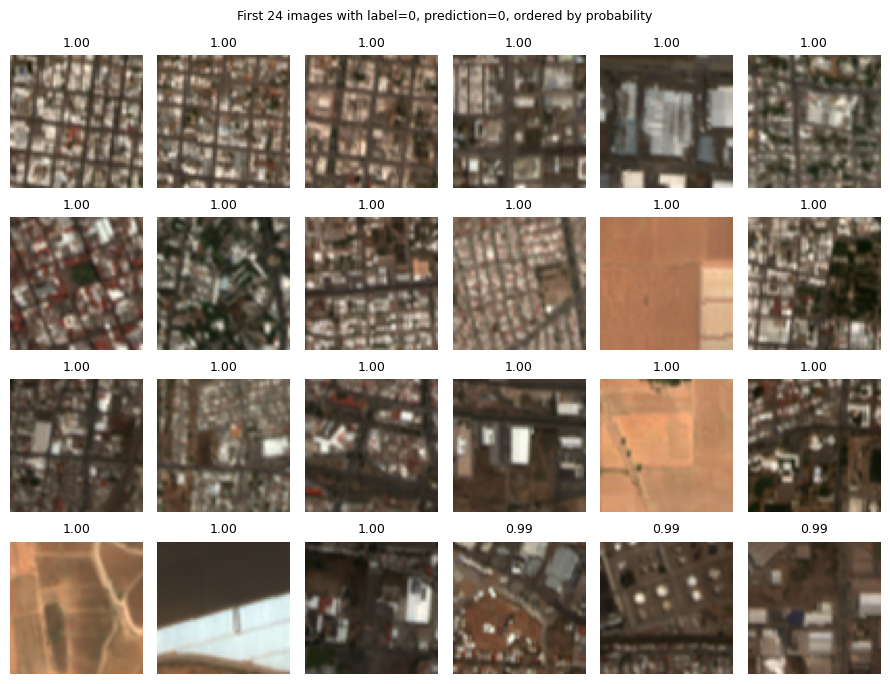

In [22]:
utils.plot_classified_images(X_test, df_ft)

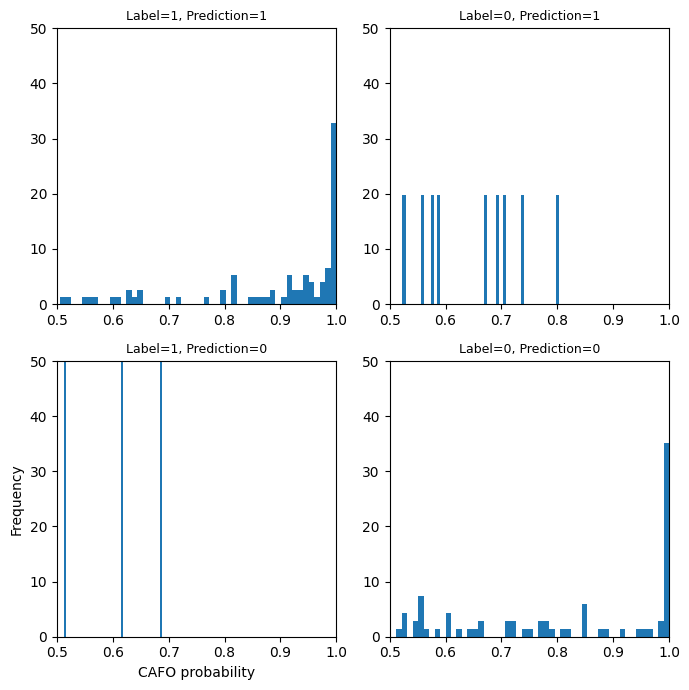

In [23]:
utils.probability_hist(df_ft)